## TNG300-1 Profiles
#### This notebook aims to produce the stellar mass density profiles of central galaxies drawn from the TNG300-1 simulation.

#### **Data files and organization**

1. Create an environment variable `$TNG_DATA` pointing to the top-level directory of the Illustris data and choose a simulation, for example TNG300-1. Next, create the directory structure you need (see also the tutorial for more, potentially confusing, details):

    cd $TNG_DATA  
    mkdir TNG300-1  
    mkdir TNG300-1/output  
    mkdir -p TNG300-1/postprocessing/offsets  

2. From the top-level page for this simulation, e.g., http://www.tng-project.org/data/downloads/TNG300-1:

    2a. Grab the appropriate simulation.hdf5 file.  
    2b. Choose a snapshot number, typically the one corresponding to z=0 (here, equal to snapshot-99), and download the appropriate offsets_099.hdf5 file into the postprocessing/offsets directory.  
    2c. Grab all the group catalogs for this snapshot and put them into the output/groups_099 directory.



You should modify your basePath as necessary to point to your local files, however you have organized them. By default they assume the following directory structure: (e.g for snapshot 99):  
* group catalogs: `basePath/groups_099/groups_099.N.hdf5`

* snapshots:  `basePath/snapdir_099/snap_099.N.hdf5`   

**Initial imports**

In [67]:
import os, time
import illustris_python as il
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
import requests

baseUrl = 'http://www.illustris-project.org/api/'
headers = {"api-key":"e74bff8a3f17fa1497eb8c11243b2b87"}

def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()
    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    return r

### Read all the subhalos in snapshot 99 (corresponding to z=0).

* http://www.tng-project.org/data/downloads/TNG300-1/
* http://www.tng-project.org/data/docs/specifications/#sec1a
        
Every HDF5 snapshot contains several groups: "Header", "Parameters", "Configuration", and five 
"PartTypeX" groups, for the following particle types (the DM only runs have a single PartType1 group):

    PartType0 - GAS
    PartType1 - DM
    PartType2 - (unused)
    PartType3 - TRACERS
    PartType4 - STARS & WIND PARTICLES
    PartType5 - BLACK HOLES

**There are two requirements to use a simulation.hdf5 file**

* actual data files must be organized exactly as suggested and described in the example scripts tutorial (i.e., an "output" directory containing a "snapdir_099" subdirectory and a "group_099" subdirectory, along with a "postprocessing" directory containing, among others, an "offsets" subdirectory).  
* HDF5 virtual datasets are a new feature, only supported by HDF5 version 1.10.x and later. This is not presently the default version installed on most clusters, which still use 1.8.x. You may have to install a newer version yourself, or request that your system administrator do so. Note! Files created with advanced features of the new HDF5 library series are not backwards compatible. The old 1.8.x series of HDF5 reaches end of life in 2019, so it is a good idea regardless to migrate. In Python, you will also need a fairly new version of h5py (e.g. 2.9.x).


In [45]:
# this is all stuff with the simulation file that we soon came to realize that it just doesn't work with us ,...

In [46]:
#with h5py.File(os.path.join(basepath, 'simulation.hdf5'), 'r') as f:
#    for key in f['Groups/99/Subhalo'].keys():
#        if type(f['Groups/99/Subhalo/{}'.format(key)]) is h5py._hl.dataset.Dataset:
#           print(key, f['Groups/99/Subhalo/{}'.format(key)][()].shape

In [47]:
#ff = h5py.File(os.path.join(basepath, 'simulation.hdf5'), 'r')
#dir(f['Groups/99/Subhalo/SubhaloMass'])
#if type(ff['Groups/99/Subhalo/SubhaloMass']) is h5py._hl.dataset.Dataset:
#    print('Yo')
    #f['Groups/99/Subhalo/SubhaloMass'].len()

In [48]:
#for key in ff['Groups/99/Subhalo/StellarMasses'].keys():
#   print(key, ff['Groups/99/Subhalo/StellarMasses/{}'.format(key)][()].max()) 

In [49]:
#with h5py.File(os.path.join(basepath, 'output', 'groups_099', 'fof_subhalo_tab_099.3.hdf5'), 'r') as f2:
#    print(f2.keys())
#    print(f2['Group'].keys())
#    mm = f2['Subhalo/SubhaloMassInHalfRad']

In [60]:
basePath = '/home/desi/tng300-1/output'

#### Read the FoF group catalog at z=0.

In [23]:
def read_groupcat(snapshot=99):
    """Read the fields we care about from a given group catalog in a 
    specified snapshot (redshift).
    
    http://www.tng-project.org/data/docs/specifications/#sec1a
    """
    fields = ['GroupFirstSub', 'GroupMass', 'GroupLenType', 'GroupPos', 
              'Group_M_Crit200', 'Group_M_Crit500', 'Group_R_Crit200', 'GroupNsubs', 'GroupSFR', 
              'GroupMassType']
    print('Reading the following group catalog fields from snapshot {}:'.format(snapshot))
    print(fields)
    cat = il.groupcat.loadHalos(basePath, snapshot, fields=fields)
    return cat

In [24]:
%time groupcat = read_groupcat()

Reading the following group catalog fields from snapshot 99:
['GroupFirstSub', 'GroupMass', 'GroupLenType', 'GroupPos', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_R_Crit200', 'GroupNsubs', 'GroupSFR', 'GroupMassType']
CPU times: user 6.07 s, sys: 1.59 s, total: 7.66 s
Wall time: 1min


For fun, plot the distribution of halo masses for the full group catalog.  We're interested in the most massive ones, >10^13 Msun.

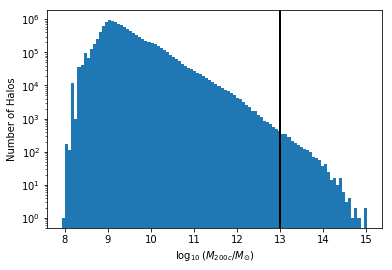

In [52]:
good = groupcat['Group_M_Crit200'] > 0
fig, ax = plt.subplots()
_ = ax.hist(np.log10(groupcat['Group_M_Crit200'][good] * 1e10), bins=100)
ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}\,(M_{200c}/M_{\odot})$')
ax.set_ylabel('Number of Halos')
ax.axvline(x=13, color='k', lw=2, ls='-')

In [53]:
igroup = np.where(groupcat['Group_M_Crit200'] * 1e10 > 1e13)[0]
print('Found {} groups with M>10^13 Msun'.format(len(igroup)))

Found 2522 groups with M>10^13 Msun


In [327]:
# Key fields to track: 
# SubhaloFlag, SubhaloPos, SubhaloSFR, SubhaloMass, SubhaloLenType

# Types are: 0=gas; 1=DM; 2=not used; 3=tracers; 4=stars/wind; 5=BH
starsindx = il.snapshot.partTypeNum('stars')  # 4

fields = ['SubhaloFlag', 'SubhaloPos', 'SubhaloSFR', 'SubhaloMass', 'SubhaloLenType']
for ig in igroup[:5]:
    nsubhalos = groupcat['GroupNsubs'][ig]
    firstsub = groupcat['GroupFirstSub'][ig]
    print('Working on subhalo ID {} (out of {} subhalos) in FoF group {}'.format(firstsub, nsubhalos, ig))
    subhalo = il.groupcat.loadSingle(basePath, 99, subhaloID=firstsub)
    print('  Subhalo mass = {:.3f} (group mass = {:.3f})'.format(
        np.log10(subhalo['SubhaloMassType'][starsindx] * 1e10), 
        np.log10(groupcat['Group_M_Crit200'][ig] * 1e10)))

    print(subhalo['SubhaloMassInHalfRadType'][starsindx] * 1e10 / 1e12)
    #for ff in fields:
    #    print(subhalo[ff])
    #print()

Working on subhalo ID 0 (out of 11748 subhalos) in FoF group 0
  Subhalo mass = 12.725 (group mass = 15.017)
2.6547396850585936
Working on subhalo ID 11748 (out of 6160 subhalos) in FoF group 1
  Subhalo mass = 12.577 (group mass = 14.947)
1.8875639343261719
Working on subhalo ID 17908 (out of 4828 subhalos) in FoF group 2
  Subhalo mass = 12.515 (group mass = 14.845)
1.6351116943359374
Working on subhalo ID 22736 (out of 5142 subhalos) in FoF group 3
  Subhalo mass = 12.431 (group mass = 14.785)
1.3498045349121093
Working on subhalo ID 27878 (out of 5296 subhalos) in FoF group 4
  Subhalo mass = 12.443 (group mass = 14.756)
1.3866032409667968


In [54]:
subhalo = il.groupcat.loadSingle(basePath, 99, subhaloID=0)

In [480]:
starsindx = il.snapshot.partTypeNum('stars')  # 4
subhalomass = []
groupmass = []
halfmassrad = []


fields = ['SubhaloFlag', 'SubhaloPos', 'SubhaloSFR', 'SubhaloMass', 'SubhaloLenType']
for ig in igroup:
    nsubhalos = groupcat['GroupNsubs'][ig]
    firstsub = groupcat['GroupFirstSub'][ig]
    subhalo = il.groupcat.loadSingle(basePath, 99, subhaloID=firstsub)
    subhalomass.append(np.log10(subhalo['SubhaloMassType'][starsindx] * 1e10))
    groupmass.append(np.log10(groupcat['Group_M_Crit200'][ig] * 1e10))
    halfmassrad.append(np.log10(subhalo['SubhaloMassInRadType'][starsindx] * 1e10))

#### Just the data that is above 10^14 (same as Annalisa's paper)

In [120]:
starsindx = il.snapshot.partTypeNum('stars')  # 4
subhalomass = []
groupmass = []
halfmassrad = []
ids = []

fields = ['SubhaloFlag', 'SubhaloPos', 'SubhaloSFR', 'SubhaloMass', 'SubhaloLenType']
for ig in igroup:
    nsubhalos = groupcat['GroupNsubs'][ig]
    firstsub = groupcat['GroupFirstSub'][ig]
    subhalo = il.groupcat.loadSingle(basePath, 99, subhaloID=firstsub)
    
    sub = np.log10(subhalo['SubhaloMassType'][starsindx] * 1e10)
    half = np.log10(subhalo['SubhaloMassInRadType'][starsindx] * 1e10) # I'm guessing this is where it is below 2 x the half mass rad
    group = np.log10(groupcat['Group_M_Crit500'][ig] * 1e10)
    
    if group > 14:
        subhalomass.append(sub)
        groupmass.append(group)
        halfmassrad.append(half)
        ids.append(firstsub)

In [121]:
print(len(subhalomass), len(groupmass), len(halfmassrad), len(ids))

75 75 75 75


Text(0.5, 1.0, 'Stellar mass as a function of total halo mass')

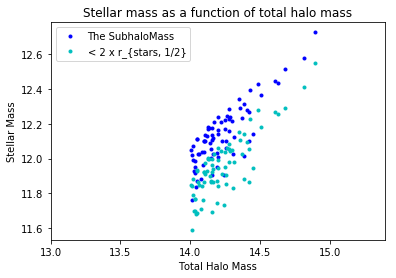

In [122]:
fig, ax = plt.subplots()
_ = ax.plot(groupmass, subhalomass, 'b.', label = 'The SubhaloMass')
_ = ax.plot(groupmass, halfmassrad, 'c.', label='< 2 x r_{stars, 1/2}')
plt.legend(loc='upper left')
ax.set_xlabel('Total Halo Mass')
ax.set_ylabel('Stellar Mass')
ax.set_xlim([13, 15.4])
plt.title('Stellar mass as a function of total halo mass')
#ax.set_ylim([11, 13])
#plt.savefig('StellarMassvsTotalMass')

In [91]:
# so for the rest of her graph -- you need different apertures - and these happen to be in simulation.hdf5 file:

In [92]:
basepath = '/home/desi/tng300-1'

In [93]:
ff = h5py.File(os.path.join(basepath, 'simulation.hdf5'), 'r')
#dir(f['Groups/99/Subhalo/SubhaloMass'])
if type(ff['Groups/99/Subhalo/SubhaloMass']) is h5py._hl.dataset.Dataset:
    print('Yo')
    #f['Groups/99/Subhalo/SubhaloMass'].len()

Yo


In [94]:
for key in ff['Groups/99/Subhalo/StellarMasses'].keys():
    print(key, ff['Groups/99/Subhalo/StellarMasses/{}'.format(key)][()].max())

Done 0.0
StellarMasses_in_r100ckpc 0.0
StellarMasses_in_r100pkpc 0.0
StellarMasses_in_r10ckpc 0.0
StellarMasses_in_r10pkpc 0.0
StellarMasses_in_r30ckpc 0.0
StellarMasses_in_r30pkpc 0.0
StellarMasses_in_r50ckpc 0.0
StellarMasses_in_r50pkpc 0.0


For the five most massive subhalos, load all their fields from the group catalog and print a gas function (gas mass over total baryonic mass) in the stellar half mass radius.

In [63]:
GroupFirstSub = il.groupcat.loadHalos(basePath,99, fields=['GroupFirstSub'])

In [64]:
ptNumGas = il.snapshot.partTypeNum('gas')  # 0
ptNumStars = il.snapshot.partTypeNum('stars')  # 4
stellarmass = []
gasmass = []
totalmass = []
central_galaxies = []

for i in range(5):
    all_fields = il.groupcat.loadSingle(basePath, 99, subhaloID=GroupFirstSub[i])
    gas_mass = all_fields['SubhaloMassInHalfRadType'][ptNumGas]
    stars_mass = all_fields['SubhaloMassInHalfRadType'][ptNumStars]
    frac = gas_mass / (gas_mass + stars_mass)
    total_mass = all_fields['SubhaloMass']
    stellarmass.append(stars_mass)
    gasmass.append(gas_mass)
    totalmass.append(total_mass)
    central_galaxies.append(GroupFirstSub[i])
    print(GroupFirstSub[i])

0
11748
17908
22736
27878


In [68]:
subhalo_mass = []
subhalo_position = []
subhalo_sfr = []
subhalo_masstype = []
subhalo_metallicity = []
subhalo_cm = []
subhalo_pos = []

for c in central_galaxies:
    snap_url = "http://www.tng-project.org/api/TNG300-1/snapshots/99/subhalos/"+str(c)+"/info.json"
    snap = get(snap_url)
    subhalo_mass.append(snap['SubhaloMass'])
    subhalo_position.append(snap['SubhaloPos'])
    subhalo_sfr.append(snap['SubhaloSFR'])
    subhalo_masstype.append(snap['SubhaloMassType'])
    subhalo_metallicity.append(snap['SubhaloGasMetallicity'])
    subhalo_cm.append(snap['SubhaloCM'])
    subhalo_pos.append(snap['SubhaloPos']) 

In [70]:
subhalo_pos

[[43718.8125, 48813.640625, 147594.953125],
 [81856.5078125, 121018.3203125, 194532.6875],
 [119228.15625, 67811.4921875, 196039.390625],
 [86512.828125, 81893.5625, 52624.5546875],
 [134485.390625, 36361.37890625, 35270.6171875]]

download individual [cutout](http://www.tng-project.org/data/search/?sim=TNG300-1&snap=99&snap_num=&form-TOTAL_FORMS=1&form-INITIAL_FORMS=1&form-MIN_NUM_FORMS=0&form-MAX_NUM_FORMS=1000&form-0-field=id&form-0-min=0&form-0-max=11749) that you want 

In [84]:
#f0 = h5py.File('/home/desi/tng300-1/output/groups_099/cutout_0.hdf5')
#f1 = h5py.File('/home/desi/tng300-1/output/groups_099/cutout_11748.hdf5')
f2 = h5py.File('/home/desi/tng300-1/output/groups_099/cutout_17908.hdf5')
#f3 = h5py.File('/home/desi/tng300-1/output/groups_099/cutout_22736.hdf5')
#f4 = h5py.File('/home/desi/tng300-1/output/groups_099/cutout_27878.hdf5')

In [76]:
%time coordinates = np.array(list(f2['PartType4/Coordinates'][:100000]))

CPU times: user 65.8 ms, sys: 3.81 ms, total: 69.6 ms
Wall time: 149 ms


In [77]:
stellar_masses = np.array(list(f2['PartType4/Masses'][:100000]))

In [78]:
radius = []
central_galaxy = subhalo_pos[2]

for c in range(10000):
    x = coordinates[c][0]-central_galaxy[0]
    y = coordinates[c][1]-central_galaxy[1]
    z = coordinates[c][2]-central_galaxy[2]
    
    radius.append(np.sqrt(x**2 + y**2 + z**2))

In [79]:
len(radius)

10000

In [80]:
sum_stellar_mass = []
for r in range(0,len(radius)):
    ww = np.where(radius<radius[r])
    new_stellar_mass = stellar_masses
    summed_mass = np.sum(new_stellar_mass[ww])
    sum_stellar_mass.append(summed_mass)

In [81]:
len(sum_stellar_mass)

10000

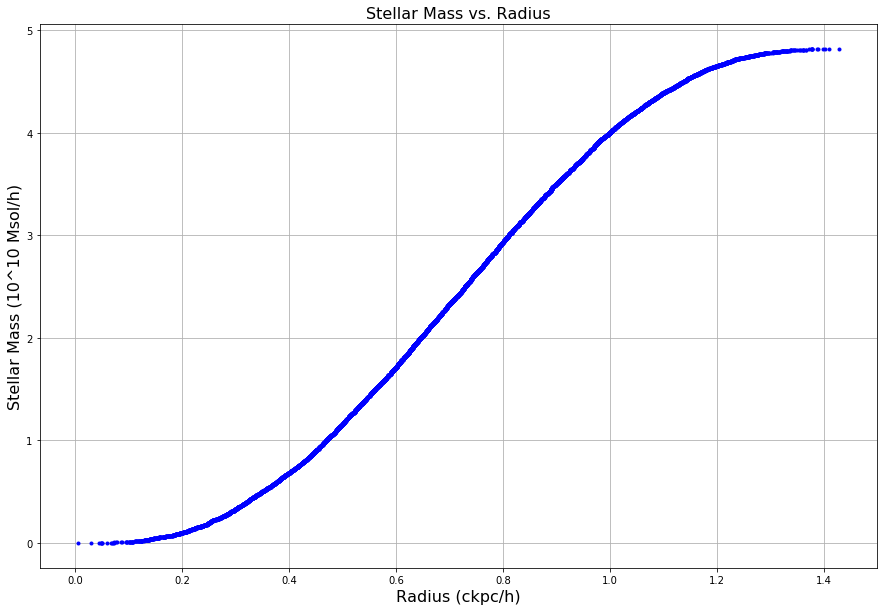

In [82]:
plt.figure(figsize=(15,10))
plt.plot(radius, sum_stellar_mass, 'b.')
plt.title('Stellar Mass vs. Radius',fontsize=16)
plt.xlabel('Radius (ckpc/h)',fontsize=16)
plt.ylabel('Stellar Mass (10^10 Msol/h)',fontsize=16)
plt.grid()
#plt.savefig('stellarmass_v_rad.png')

In [90]:
# close the file so we don't waste resources
f2.close()

### Everything from here below is just me messing around with stuff and talking to myself 

In [21]:
# kay so now try to push to a function so we can overlay the different galaxies 

In [22]:
# so we need coordinates and mass from each galaxy 
# each subhalo_pos[x] correlates to a different galaxy
# subhalo_pos[0] = f0, subhalo_pos[1] = f1 and so on and so forth

In [23]:
# figure out how to input the different ID ? or different fN
# so loop over 5 of them and get coordinates and stellar_masses
# however it takes forever to load coordinates and stellar_masses so until we 
# have better resources -- we are grabbing only 100000 (idk why this took me forever to figure out)

In [35]:
rad = []
cengal = subhalo_pos[0]
def get_radius(f):
    coordinates = np.array(list(f['PartType4/Coordinates'][:100000, :]))
    for c in range(10000):
        x = coordinates[c][0]-cengal[0]
        y = coordinates[c][1]-cengal[1]
        z = coordinates[c][2]-cengal[2]
    
        rad.append(np.sqrt(x**2 + y**2 + z**2))
    return rad

In [46]:
sum_stellar_mass = []
def get_stellar_mass(f):
    stellar_masses = np.array(list(f['PartType4/Masses'][:100000]))   
    radius = get_radius(f)
    for r in range(0, len(radius)):       
        ww = np.where(radius<radius[r])
        new_stellar_mass = stellar_masses
        summed_mass = np.sum(new_stellar_mass[ww])
        sum_stellar_mass.append(summed_mass)
    return sum_stellar_mass

In [47]:
def plot(f):
    sum_stellar_mass = get_stellar_mass(f)
    radius = get_radius(f)
    plt.figure(figsize=(15,10))
    plt.plot(radius, sum_stellar_mass, 'b.')
    plt.title('Stellar Mass vs. Radius',fontsize=16)
    plt.xlabel('Radius (ckpc/h)',fontsize=16)
    plt.ylabel('Stellar Mass (10^10 Msol/h)',fontsize=16)
    plt.grid()

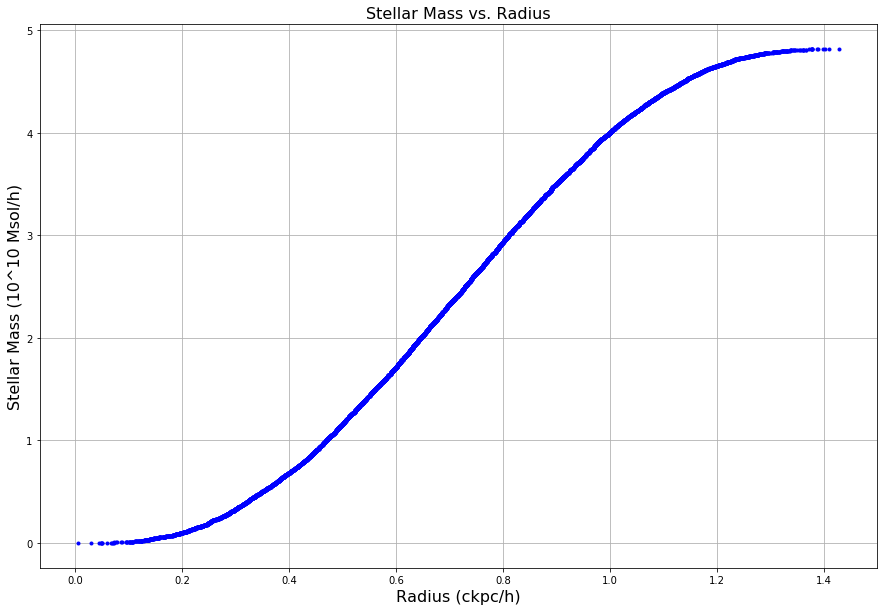

In [91]:
plt.figure(figsize=(15,10))
plt.plot(radius, sum_stellar_mass, 'b.')
plt.title('Stellar Mass vs. Radius',fontsize=16)
plt.xlabel('Radius (ckpc/h)',fontsize=16)
plt.ylabel('Stellar Mass (10^10 Msol/h)',fontsize=16)
plt.grid()

#### stellar mass as a function of total mass

In [107]:
f1 = h5py.File('/home/desi/tng300-1/output/groups_099/cutout_11748.hdf5')
coordinates = np.array(list(f1['PartType4/Coordinates'][:10000]))
stellar_masses = np.array(list(f1['PartType4/Masses'][:10000]))